# Climatologies de l'atmosphère à partir de réanalyses météorologiques

Auteur : FERRY Frédéric (DESR/ENM/C3M) - juillet 2020

L’objectif de ces activités Python est de mettre en évidence les grands traits de la circulation générale atmosphérique à travers l’étude des principaux paramètres atmosphériques moyens : température, vent, pression, géopotentiel, humidité, précipitations. On exploitera pour cela des réanalyses météorologiques qui combinent des observations et le résultat de modèles numériques afin de constituer la meilleure connaissance possible de l’état de l'atmosphère, sur un domaine global, pour une date et une heure données. Ces réanalyses seront moyennées sur une longue période afin de fournir des climatologies saisonnières de l’atmosphère. On exploitera ici des fichiers de données au format netcdf issus des réanalyses américaines NCEP/NCAR (1948-présent, résolution horizontale de 2.5x2.5°, 17 niveaux pression sur la verticale).

Les fichiers de données au format netcdf doivent être téléchargés et placés dans le répertoire data.

Concepts Python illustrés :
- Calcul de climatologies à partir de données météorologiques au format netcdf (xarray)
- Tracé de cartes globales sur surface horizontale ou isobare (cartopy)
- Animations (matplotlib)

In [1]:
%matplotlib inline

import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

import warnings
warnings.filterwarnings('ignore')

# Traitement des données

In [2]:
year1='1990'
year2='2019'
diri="./data/"
dir_anim="./anim/"

In [3]:

# z, T, u, v, w, q
fz    = xr.open_dataset(diri+"hgt.mon.mean.nc").sel(time=slice(year1,year2))
ft    = xr.open_dataset(diri+"air.mon.mean.nc").sel(time=slice(year1,year2))+273.15
fu    = xr.open_dataset(diri+"uwnd.mon.mean.nc").sel(time=slice(year1,year2))
fv    = xr.open_dataset(diri+"vwnd.mon.mean.nc").sel(time=slice(year1,year2))

# precip, MSLP, T2m, PW
fpr = xr.open_dataset(diri+"precip.mon.mean.nc").sel(time=slice(year1,year2))
fp    = xr.open_dataset(diri+"slp.mon.mean.nc").sel(time=slice(year1,year2))
ft2m  = xr.open_dataset(diri+"air2m.mon.mean.nc").sel(time=slice(year1,year2))
fpw   = xr.open_dataset(diri+"pr_wtr.mon.mean.nc").sel(time=slice(year1,year2))

# Latitudes, niveaux verticaux
lat  = ft.lat.values
lat_t2m  = ft2m.lat.values
lat_pr  = fpr.lat.values
lat_pw  = fpw.lat.values
lev = fz.level.values

print(ft)
print(lev)

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 360)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2019-12-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, level, lat, lon) float32 253.01999 253.01999 ... 246.24515
Attributes:
    description:     Data from NCEP initialized reanalysis (4x/day).  These a...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Mon Jul  5 21:45:36 1999: ncrcat air.mon.mean.nc /Dataset...
    title:          monthly mean air from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...
[1000.  925.  850.  700.  600.  500.  400.  300.  250.  200.  150.  100.

In [4]:
seasons=['DJF','JJA','MAM','SON']

# z, T, u, v
fz_mean = fz.groupby('time.season').mean('time')
ft_mean = ft.groupby('time.season').mean('time')
fu_mean = fu.groupby('time.season').mean('time')
fv_mean = fv.groupby('time.season').mean('time')

# precip, MSLP, T2m, PW
fpr_mean = fpr.groupby('time.season').mean('time')
fp_mean = fp.groupby('time.season').mean('time')
ft2m_mean = ft2m.groupby('time.season').mean('time')
fpw_mean = fpw.groupby('time.season').mean('time')

#Variables
z0 = fz_mean['hgt']
t0 = ft_mean['air']
u0 = fu_mean['uwnd']
v0 = fv_mean['vwnd']
pr0 = fpr_mean['precip']

p0 = fp_mean['slp']
t2m0 = ft2m_mean['air']
pw0 = fpw_mean['pr_wtr']

print(z0.shape)
print(p0.shape)

(4, 17, 73, 144)
(4, 73, 144)


In [5]:
def lonflip(da):
    lon_name = 'lon'
    da['_longitude_adjusted'] = xr.where(
        da[lon_name] > 180,
        da[ lon_name] - 360,
        da[lon_name])
    da = (
        da
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(da._longitude_adjusted)})
        .drop(lon_name))
    da = da.rename({'_longitude_adjusted': lon_name})
    return da

In [6]:
z=lonflip(z0)
u=lonflip(u0)
v=lonflip(v0)
t=lonflip(t0)

pr=lonflip(pr0)
p=lonflip(p0)
t2m=lonflip(t2m0)
pw=lonflip(pw0)

lon  = z.lon.values

# Fonctions graphiques

In [172]:
#proj=ccrs.PlateCarree()
proj=ccrs.EqualEarth()

def plot_background(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    return ax

In [7]:
levels_z = np.arange(5000,6050,50)
levels_t = np.arange(220,312,2)
levels_u = np.arange(-30,85,5)
levels_pr = np.arange(0,15,1)
levels_p = np.arange(970,1042,2)
levels_t2m = np.arange(200,322,2)
levels_pw = np.arange(0,60,2.5)

# Cartes globe tournant

In [8]:
iseason=1

Original shape - (4, 94, 192)
New shape - (4, 94, 193)


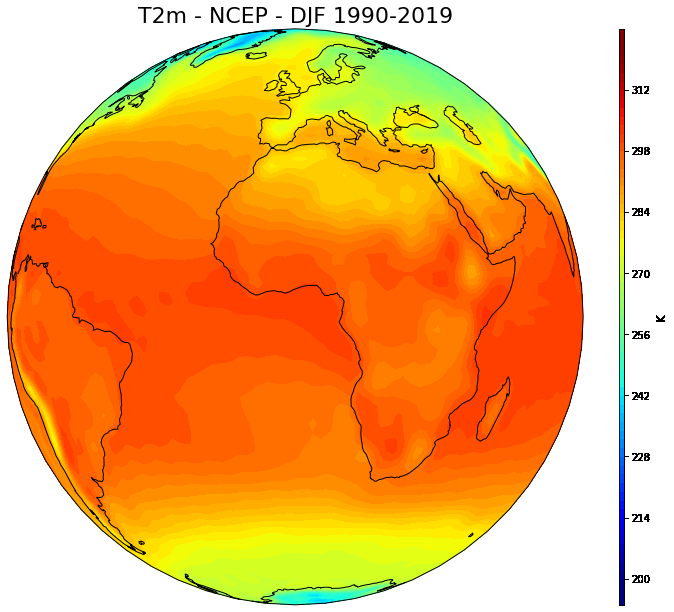

In [175]:
print("Original shape -", t2m.shape)
lon0 = t2m.coords['lon']
lon_idx = t2m.dims.index('lon')
t2m2, lon2 = add_cyclic_point(t2m.values, coord=lon0, axis=lon_idx)
print("New shape -", t2m2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat_t2m, t2m2[iseason,:,:], levels=levels_t2m, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('K', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('T2m - NCEP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'T2m_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)

Original shape - (4, 17, 73, 144)
New shape - (4, 17, 73, 145)


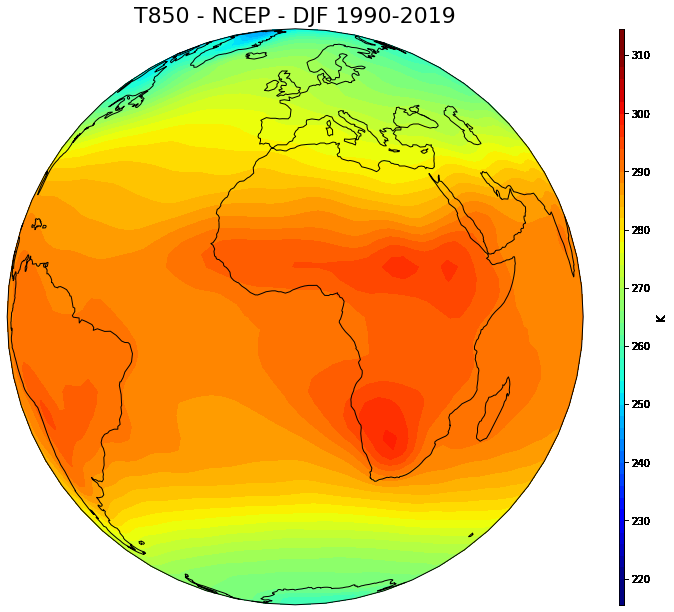

In [176]:
plev=850
ilev=list(lev).index(plev)

print("Original shape -", t.shape)
lon0 = t.coords['lon']
lon_idx = t.dims.index('lon')
t2, lon2 = add_cyclic_point(t.values, coord=lon0, axis=lon_idx)
print("New shape -", t2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat, t2[iseason,ilev,:,:], levels=levels_t, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('K', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('T'+str(plev)+' - NCEP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'T'+str(plev)+'_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)

Original shape - (4, 17, 73, 144)
New shape - (4, 17, 73, 145)


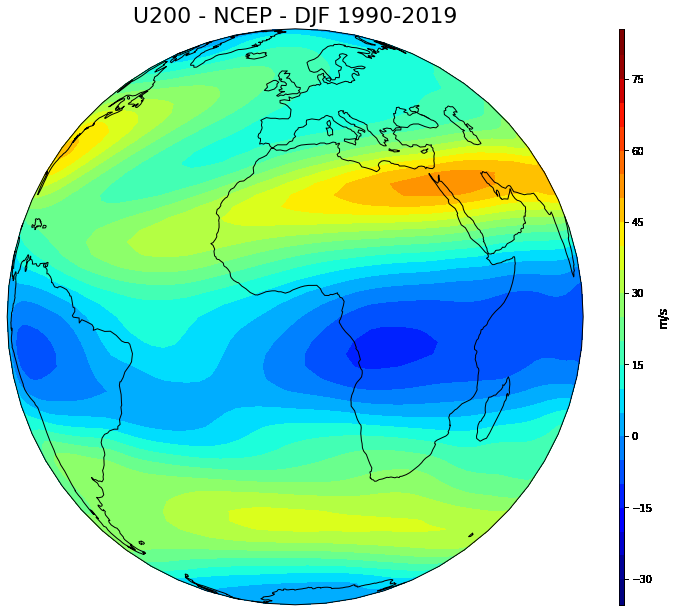

In [177]:
plev=200
ilev=list(lev).index(plev)

print("Original shape -", u.shape)
lon0 = u.coords['lon']
lon_idx = u.dims.index('lon')
u2, lon2 = add_cyclic_point(u.values, coord=lon0, axis=lon_idx)
print("New shape -", u2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat, u2[iseason,ilev,:,:], levels=levels_u, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('m/s', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('U'+str(plev)+' - NCEP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'U'+str(plev)+'_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)

Original shape - (4, 73, 144)
New shape - (4, 73, 145)


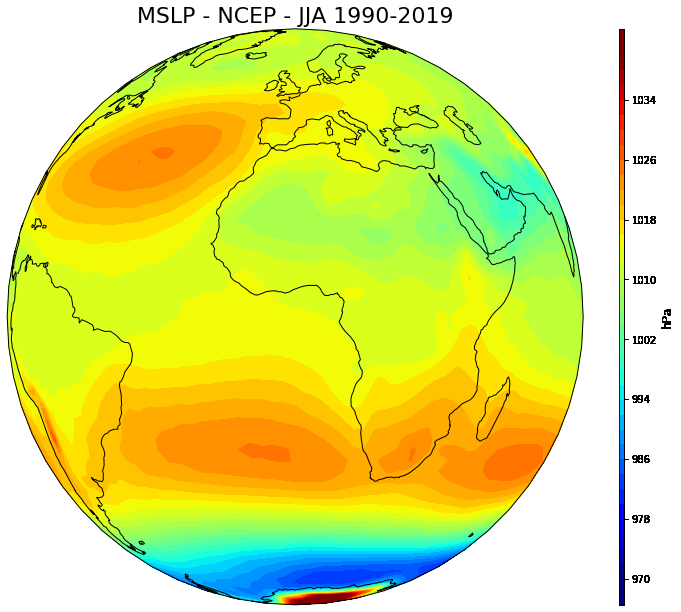

In [9]:
print("Original shape -", p.shape)
lon0 = p.coords['lon']
lon_idx = p.dims.index('lon')
p2, lon2 = add_cyclic_point(p.values, coord=lon0, axis=lon_idx)
print("New shape -", p2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat, p2[iseason,:,:], levels=levels_p, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('hPa', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('MSLP - NCEP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'MSLP_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)

Original shape - (4, 17, 73, 144)
New shape - (4, 17, 73, 145)


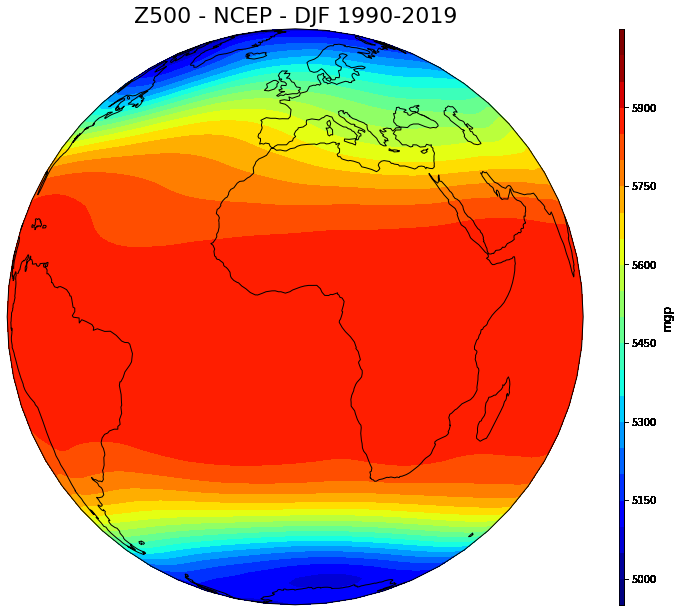

In [179]:
plev=500
ilev=list(lev).index(plev)

print("Original shape -", z.shape)
lon0 = z.coords['lon']
lon_idx = z.dims.index('lon')
z2, lon2 = add_cyclic_point(z.values, coord=lon0, axis=lon_idx)
print("New shape -", z2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat, z2[iseason,ilev,:,:], levels=levels_z, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('mgp', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('Z'+str(plev)+' - NCEP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'Z'+str(plev)+'_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)

Original shape - (4, 73, 144)
New shape - (4, 73, 145)


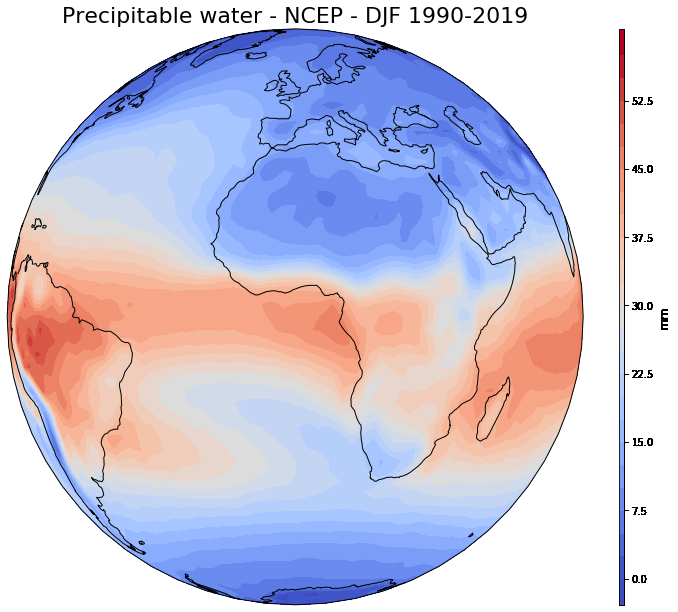

In [180]:
print("Original shape -", pw.shape)
lon0 = pw.coords['lon']
lon_idx = pw.dims.index('lon')
pw2, lon2 = add_cyclic_point(pw.values, coord=lon0, axis=lon_idx)
print("New shape -", pw2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat_pw, pw2[iseason,:,:], levels=levels_pw, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('mm', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('Precipitable water - NCEP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'PW_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)

Original shape - (4, 72, 144)
New shape - (4, 72, 145)


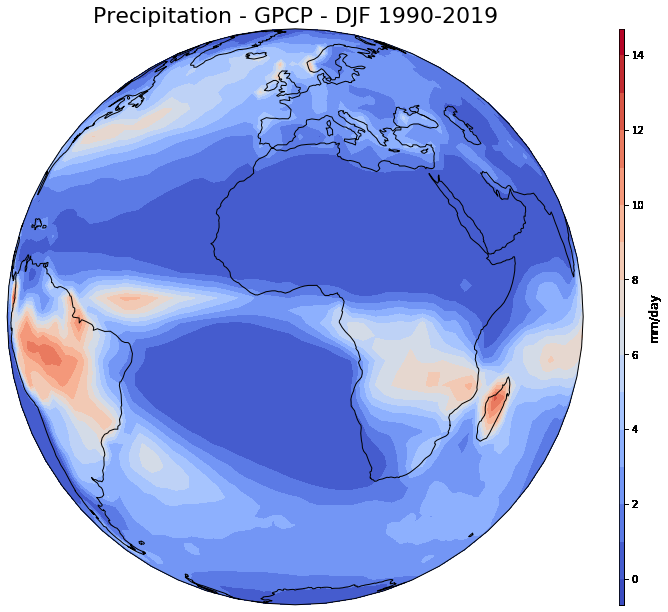

In [181]:
print("Original shape -", pr.shape)
lon0 = pr.coords['lon']
lon_idx = pr.dims.index('lon')
pr2, lon2 = add_cyclic_point(pr.values, coord=lon0, axis=lon_idx)
print("New shape -", pr2.shape)

def animate(i):
    longitude = i
    ax = plt.gca()
    ax.remove()
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=0, central_longitude=longitude))
    cf=ax.contourf(lon2, lat_pr, pr2[iseason,:,:], levels=levels_pr, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
    cb=plt.colorbar(cf, orientation='vertical', aspect=100, shrink=0.8, pad=0.05, extendrect='True')
    cb.set_label('mm/day', size='large')
    ax.set_global()
    ax.coastlines()
    ax.set_title('Precipitation - GPCP - '+seasons[iseason]+' '+year1+'-'+year2, fontsize=22)

plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
    plt.gcf(), animate,
    frames=np.linspace(0, 360, 40),
    interval=125, repeat=True)
ani.save(dir_anim+'RR_global_'+seasons[iseason]+'.gif', writer='imagemagick', dpi=plt.gcf().dpi)